### BDA LAB 03
### NAME : Ayush Gaykar
### PRN : 20220802255


In [ ]:
!pip install findspark

In [ ]:
import findspark
findspark.init()
from pyspark.sql import SparkSession
spark = SparkSession.builder.master("local[*]").getOrCreate()

In [ ]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import col

spark = SparkSession.builder.master("local[*]").appName("AmazonTwitterData").getOrCreate()

from google.colab import files
uploaded = files.upload()

In [ ]:
import numpy as np
# Initialize Spark session
spark = SparkSession.builder.master("local[*]").appName("AmazonTwitterData").getOrCreate()

# Find the uploaded file's path (usually, it will be in the current working directory)
uploaded_file_name = list(uploaded.keys())[0]  # Get the uploaded file name

# Read the CSV file into a DataFrame
df = spark.read.option("header", "true").csv(uploaded_file_name)

# Show all the column names
print("Columns in the CSV file:")
df.columns

# Show the first few rows of the DataFrame
df.show(5)


Columns in the CSV file:
+--------------------+--------------------+----------------+-----------+-------------------+---------------------+--------------+-----------------+--------------+--------------------+-------------+-------------+--------------------+------------------+--------------------+--------------+--------------------+--------------+---------+-----------------------+-------------------------+-----------------------+-------------+---------+--------------------+
|              id_str|    tweet_created_at|user_screen_name|user_id_str|user_statuses_count|user_favourites_count|user_protected|user_listed_count|user_following|    user_description|user_location|user_verified|user_followers_count|user_friends_count|     user_created_at|tweet_language|               text_|favorite_count|favorited|in_reply_to_screen_name|in_reply_to_status_id_str|in_reply_to_user_id_str|retweet_count|retweeted|                text|
+--------------------+--------------------+----------------+---------

In [ ]:
from pyspark.sql.functions import col, lower  # Import the necessary functions

# Step 1: Map - Create a new column that contains a '1' when the word 'amazon' is found in the tweet's text
mapped_df = df.withColumn('contains_amazon',
                         (lower(col('text')).contains('amazon')).cast('int'))  # 1 if 'amazon' is found, otherwise 0

# Step 2: Reduce - Aggregate by summing up the 'contains_amazon' values to get the count
amazon_count = mapped_df.agg({'contains_amazon': 'sum'}).collect()[0][0]

# Show the result
print(f"Total occurrences of the word 'Amazon': {amazon_count}")

# Additional Optional Steps (if you want to visualize results or work further):
# - You could filter out tweets containing 'Amazon' to analyze them further,
#   or aggregate counts by other columns (e.g., by date, location, etc.).

# Example to show tweets containing 'Amazon'
amazon_tweets_df = mapped_df.filter(col('contains_amazon') == 1)
amazon_tweets_df.show(5)


Total occurrences of the word 'Amazon': 33897
+--------------------+--------------------+----------------+-----------+-------------------+---------------------+--------------+-----------------+--------------+--------------------+----------------+-------------+--------------------+------------------+--------------------+--------------+--------------------+--------------+---------+-----------------------+-------------------------+-----------------------+-------------+---------+--------------------+---------------+
|              id_str|    tweet_created_at|user_screen_name|user_id_str|user_statuses_count|user_favourites_count|user_protected|user_listed_count|user_following|    user_description|   user_location|user_verified|user_followers_count|user_friends_count|     user_created_at|tweet_language|               text_|favorite_count|favorited|in_reply_to_screen_name|in_reply_to_status_id_str|in_reply_to_user_id_str|retweet_count|retweeted|                text|contains_amazon|
+---------

+----------+--------------------+
|      date|sum(contains_amazon)|
+----------+--------------------+
|      NULL|               33897|
|2014-03-17|                NULL|
+----------+--------------------+



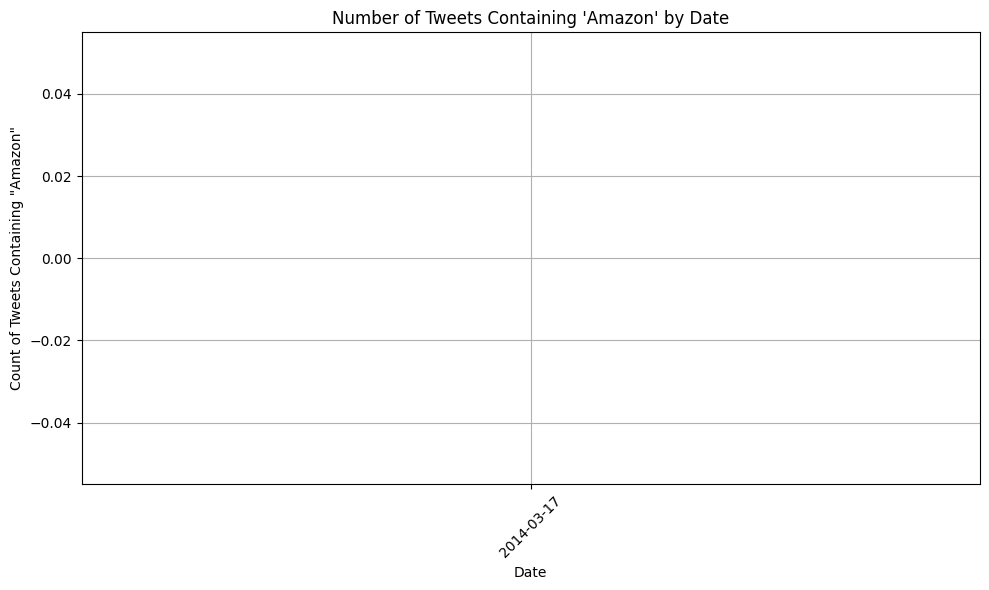

+--------------------+--------------------+----------------+-----------+-------------------+---------------------+--------------+-----------------+--------------+--------------------+----------------+-------------+--------------------+------------------+--------------------+--------------+--------------------+--------------+---------+-----------------------+-------------------------+-----------------------+-------------+---------+--------------------+---------------+----+
|              id_str|    tweet_created_at|user_screen_name|user_id_str|user_statuses_count|user_favourites_count|user_protected|user_listed_count|user_following|    user_description|   user_location|user_verified|user_followers_count|user_friends_count|     user_created_at|tweet_language|               text_|favorite_count|favorited|in_reply_to_screen_name|in_reply_to_status_id_str|in_reply_to_user_id_str|retweet_count|retweeted|                text|contains_amazon|date|
+--------------------+--------------------+---

In [ ]:
from pyspark.sql import functions as F

# Step 1: Define a function to handle multiple date formats
def convert_date_format(date_col):
    # Try converting using standard format (yyyy-MM-dd)
    formatted_date = F.to_date(date_col, "yyyy-MM-dd")

    # Handle alternative formats (e.g., 14-03-17 -> 2014-03-17)
    alt_format = F.when(
        F.to_date(date_col, "yy-MM-dd").isNotNull(),
        F.date_format(F.to_date(date_col, "yy-MM-dd"), "yyyy-MM-dd")
    ).otherwise(formatted_date)

    return alt_format

# Step 2: Apply the conversion to the 'tweet_created_at' column
mapped_df = mapped_df.withColumn(
    'date', convert_date_format(col('tweet_created_at'))
)

# Step 3: Group by date and count occurrences of 'Amazon'
amazon_by_day_df = mapped_df.groupBy('date').sum('contains_amazon').orderBy('date')

# Step 4: Show the cleaned results
amazon_by_day_df.show(5)

# Step 5: Convert the Spark DataFrame to a Pandas DataFrame for easier visualization
amazon_by_day_pd = amazon_by_day_df.toPandas()

# Step 6: Check if there are any rows with NULL dates and clean them up before plotting
amazon_by_day_pd = amazon_by_day_pd.dropna(subset=['date'])  # Drop rows with null dates

# Step 7: Visualize the result (if applicable)
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
plt.plot(amazon_by_day_pd['date'], amazon_by_day_pd['sum(contains_amazon)'], marker='o', color='b')
plt.title("Number of Tweets Containing 'Amazon' by Date")
plt.xlabel('Date')
plt.ylabel('Count of Tweets Containing "Amazon"')
plt.xticks(rotation=45)
plt.grid(True)
plt.tight_layout()
plt.show()

# Step 8: Filter and analyze tweets containing 'Amazon'
amazon_tweets_df = mapped_df.filter(col('contains_amazon') == 1)
amazon_tweets_df.show(5)


+-----------+-----+
|       word|count|
+-----------+-----+
|      here:|40536|
|     please|29157|
|         us|24932|
|      sorry|22641|
|@amazonhelp|19550|
|       look|15114|
|       like|12336|
|      reach|10844|
|    contact|10624|
|           |10370|
+-----------+-----+



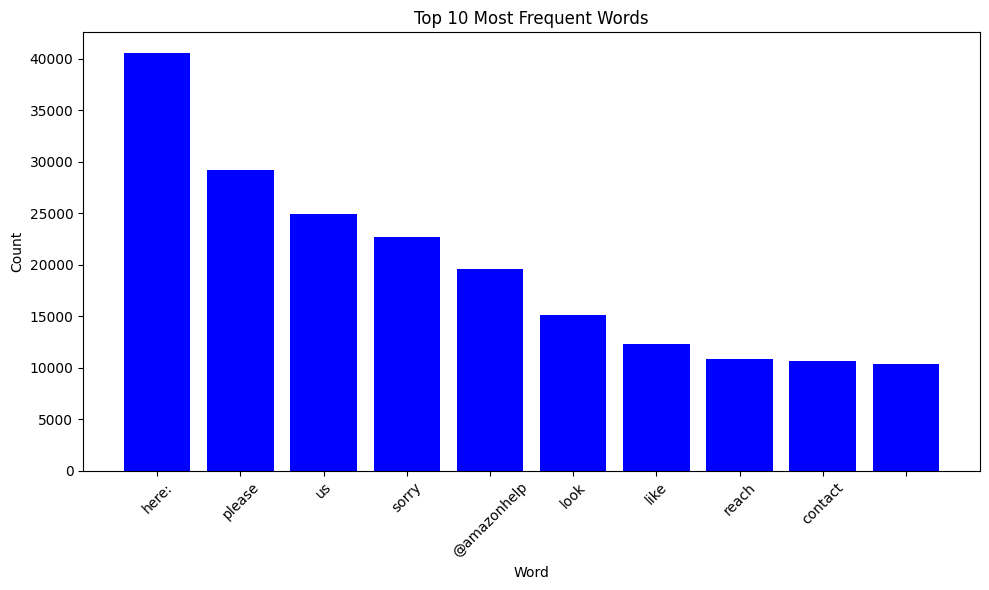

In [ ]:
from pyspark.ml.feature import Tokenizer, StopWordsRemover
from pyspark.sql import functions as F

# Step 1: Filter out rows where 'text' column is null or empty
filtered_data = mapped_df.filter((F.col("text").isNotNull()) & (F.length(F.col("text")) > 0))

# Step 2: Tokenize the 'text' column into words
tokenizer = Tokenizer(inputCol="text", outputCol="words")
tokenized_df = tokenizer.transform(filtered_data)

# Step 3: Remove stopwords from the tokenized words
remover = StopWordsRemover(inputCol="words", outputCol="filtered_words")
filtered_df = remover.transform(tokenized_df)

# Step 4: Explode the filtered words into individual rows (one word per row)
exploded_df = filtered_df.withColumn("word", F.explode(F.col("filtered_words")))

# Step 5: Group by the word and count its occurrences
word_counts_df = exploded_df.groupBy("word").count().orderBy(F.desc("count"))

# Step 6: Show the top 10 most frequent words
top_10_words_df = word_counts_df.limit(10)
top_10_words_df.show()

# Step 7: (Optional) Convert to pandas dataframe for easier visualization if needed
top_10_words_pd = top_10_words_df.toPandas()

# Step 8: (Optional) Visualize the top 10 words
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
plt.bar(top_10_words_pd['word'], top_10_words_pd['count'], color='blue')
plt.title('Top 10 Most Frequent Words')
plt.xlabel('Word')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


Total number of rows: 413247
Number of unique rows based on 'user_id': 74134
Number of duplicate rows based on 'user_id': 339113
+--------------------+--------------------+----------------+-----------+-------------------+---------------------+--------------+--------------------+--------------+--------------------+-------------+--------------------+--------------------+------------------+--------------------+--------------+--------------------+--------------+---------+-----------------------+-------------------------+-----------------------+-------------+---------+--------------------+
|              id_str|    tweet_created_at|user_screen_name|user_id_str|user_statuses_count|user_favourites_count|user_protected|   user_listed_count|user_following|    user_description|user_location|       user_verified|user_followers_count|user_friends_count|     user_created_at|tweet_language|               text_|favorite_count|favorited|in_reply_to_screen_name|in_reply_to_status_id_str|in_reply_to_use

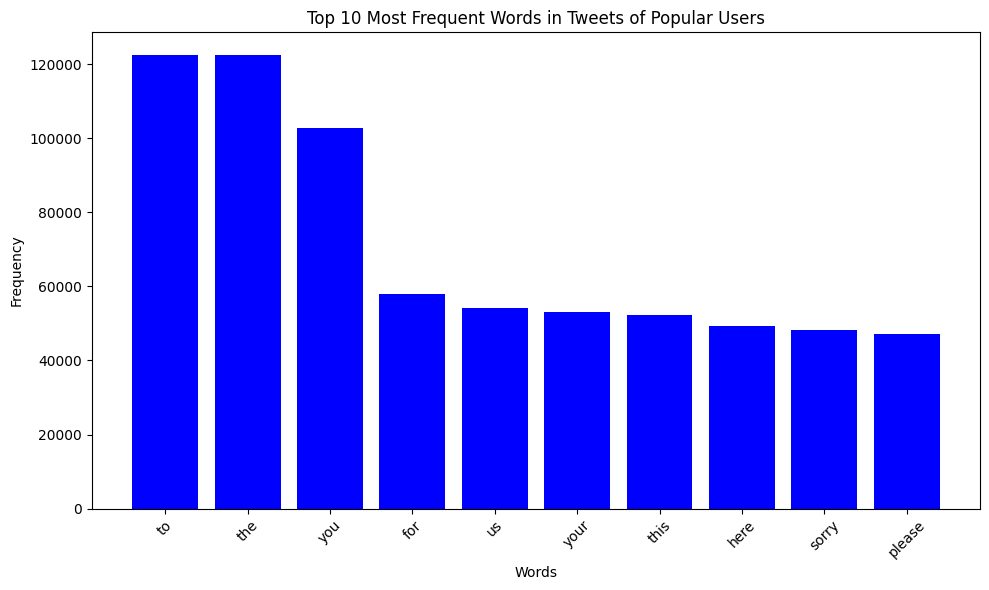

In [ ]:
df_no_duplicates = df.dropDuplicates(['user_id_str'])

# Count the number of rows after removing duplicates
total_rows = df.count()
unique_rows = df_no_duplicates.count()
duplicates_count = total_rows - unique_rows

# Print the result
print(f"Total number of rows: {total_rows}")
print(f"Number of unique rows based on 'user_id': {unique_rows}")
print(f"Number of duplicate rows based on 'user_id': {duplicates_count}")

# Convert the followers column to a numeric type (if it's not already)
df = df.withColumn("user_followers_count", col("user_followers_count").cast("int"))

# Filter for users with more than 3000 followers
popular_users = df.filter(col("user_followers_count") > 3000)

# Show the results of popular users
popular_users.show()

# Extract tweet text for popular users
tweet_rdd = popular_users.select("text_").rdd.flatMap(lambda x: x).collect()

# Create SparkContext for RDD operations
from pyspark import SparkContext
sc = SparkContext.getOrCreate()

# Create an RDD from the tweet list
tweet_rdd = sc.parallelize(tweet_rdd)

# Function for cleaning the tweet text
import string
import re

def clean_tweet(x):
    # Check if the input is None or an empty string
    if x is None:
        return ''

    # Remove all the URLs
    text00 = re.sub(r'www\S+', '', x)
    text01 = re.sub(r'http\S+', '', text00)

    # Remove all the numbers
    text1 = ''.join([i for i in text01 if not i.isdigit()])

    # Remove all punctuation marks
    text2 = text1.translate(str.maketrans('', '', string.punctuation))

    # Convert text to lowercase
    text3 = text2.lower()

    return text3


# Clean the tweet text: removing URLs, digits, punctuation, and converting to lowercase
clean_tweet_rdd = tweet_rdd.map(clean_tweet)

# Split the cleaned tweet text into words and create a pair RDD (word, 1)
map_rdd = clean_tweet_rdd.flatMap(lambda line: line.split(" ")).map(lambda word: (word, 1))

# Filter out short words or empty strings (words of length <= 1)
map_rdd_filtered = map_rdd.filter(lambda x: len(x[0]) > 1)

# Reduce by key (word) to count frequency of each word
word_counts_rdd = map_rdd_filtered.reduceByKey(lambda a, b: a + b)

# Sort the word counts in descending order based on frequency
sorted_word_counts = word_counts_rdd.takeOrdered(10, lambda a: -a[1])

# Print the top 10 most frequent words
print("Top 10 most frequent words:")
print(sorted_word_counts)

# Visualization: Bar chart for the top 10 most frequent words
words, counts = zip(*sorted_word_counts)

# Plotting the top 10 words
plt.figure(figsize=(10, 6))
plt.bar(words, counts, color='blue')
plt.title('Top 10 Most Frequent Words in Tweets of Popular Users')
plt.xlabel('Words')
plt.ylabel('Frequency')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()